==== Dataset Preview (head) ====
   Age Gender Country ProductCategory  PurchaseAmount
0   25      M      IN     Electronics            3000
1   34      F      IN        Clothing            1500
2   45      F      US        Clothing            2200
3   29      M      UK           Books             500
4   63      M      IN     Electronics            6000

==== Describe ====
              Age Gender Country ProductCategory  PurchaseAmount
count   15.000000     15      15              15       15.000000
unique        NaN      2       4               3             NaN
top           NaN      F      IN           Books             NaN
freq          NaN      8       6               6             NaN
mean    38.866667    NaN     NaN             NaN     2086.666667
std     11.679449    NaN     NaN             NaN     1558.670068
min     22.000000    NaN     NaN             NaN      450.000000
25%     30.000000    NaN     NaN             NaN      750.000000
50%     38.000000    NaN     NaN      

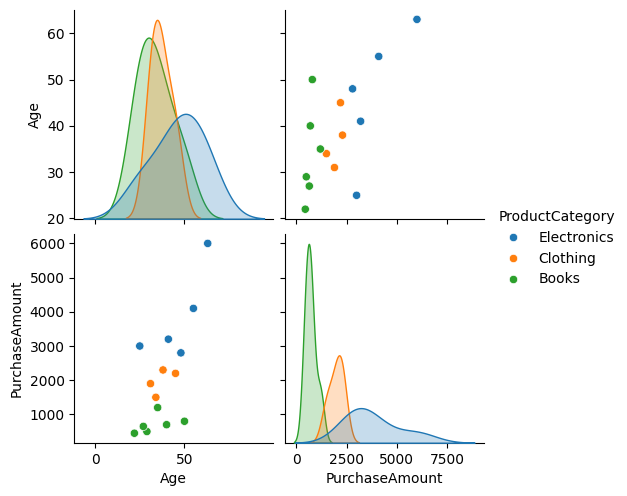

Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best params → {'model': GradientBoostingRegressor(random_state=42), 'model__max_depth': None, 'model__n_estimators': 200}

==== Performance Metrics ====
TRAIN → MAE 0.00, RMSE 0.00, R² 1.000
TEST  → MAE 918.53, RMSE 1155.35, R² 0.749

Top Feature Importances:
                       feature  importance
7        ProductCategory_Books    0.775951
8     ProductCategory_Clothing    0.068788
9  ProductCategory_Electronics    0.067858
0                          Age    0.058135
6                   Country_US    0.020882
3                   Country_DE    0.004083
5                   Country_UK    0.002436
4                   Country_IN    0.001671
2                     Gender_M    0.000156
1                     Gender_F    0.000038


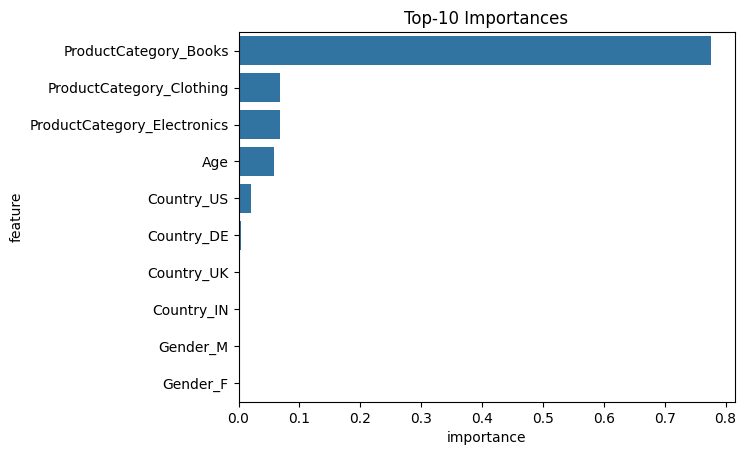

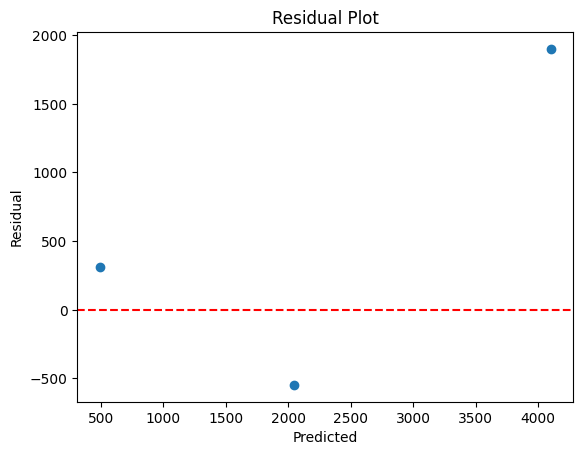

✅ Model saved to /mnt/data/best_regressor.pkl


In [18]:
from __future__ import annotations
import logging
from pathlib import Path
from typing import Dict, List
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
logging.basicConfig(level=logging.INFO, format="%(levelname)s:%(message)s")
# -------------------------------------------------------------
# 0. Paths and dataset bootstrap
# -------------------------------------------------------------
DATA_PATH = Path("/mnt/data/predictive_dataset.csv")
MODEL_PATH = Path("/mnt/data/best_regressor.pkl")
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)

if not DATA_PATH.exists():
    logging.warning("Dataset not found → generating synthetic demo dataset at %s", DATA_PATH)
    demo_data = {
        "Age": [25, 34, 45, 29, 63, 40, 22, 38, 50, 41, 35, 48, 31, 27, 55],
        "Gender": ["M", "F", "F", "M", "M", "F", "F", "M", "F", "M", "F", "M", "F", "F", "M"],
        "Country": ["IN", "IN", "US", "UK", "IN", "DE", "IN", "US", "UK", "DE", "US", "IN", "UK", "DE", "IN"],
        "ProductCategory": ["Electronics", "Clothing", "Clothing", "Books", "Electronics", "Books", "Books", "Clothing", "Books", "Electronics", "Books", "Electronics", "Clothing", "Books", "Electronics"],
        "PurchaseAmount": [3000, 1500, 2200, 500, 6000, 700, 450, 2300, 800, 3200, 1200, 2800, 1900, 650, 4100],
    }
    pd.DataFrame(demo_data).to_csv(DATA_PATH, index=False)
    logging.info("Synthetic dataset written → %s", DATA_PATH)

# -------------------------------------------------------------
# 1. Load & quick EDA with safe UTF‑8 check
# -------------------------------------------------------------
try:
    df = pd.read_csv(DATA_PATH)
except UnicodeDecodeError as e:
    logging.error("❌ Failed to read CSV as UTF‑8: %s", e)
    raise SystemExit("Provide a UTF‑8 encoded CSV at /mnt/data/predictive_dataset.csv or remove invalid characters.")

print("==== Dataset Preview (head) ====")
print(df.head())
print("\n==== Describe ====")
print(df.describe(include="all"))

# Optional pairplot (skip if running headless)
try:
    sns.pairplot(df, hue="ProductCategory")
    plt.show()
except Exception as e:
    logging.info("Pairplot skipped: %s", e)

# -------------------------------------------------------------
# 2. Train / test split
# -------------------------------------------------------------
TARGET = "PurchaseAmount"
X = df.drop(columns=[TARGET])
y = df[TARGET]
stratify_option = df["ProductCategory"] if "ProductCategory" in df.columns and df["ProductCategory"].nunique() > 1 else None
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=stratify_option)

# -------------------------------------------------------------
# 3. Preprocessing & feature selection
# -------------------------------------------------------------
num_feats: List[str] = ["Age"]
cat_feats: List[str] = [c for c in ["Gender", "Country", "ProductCategory"] if c in df.columns]

numeric_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("best_num", SelectKBest(f_regression, k="all")),
])
cat_pipe = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ("best_cat", SelectKBest(f_regression, k="all")),
])
preproc = ColumnTransformer([
    ("num", numeric_pipe, num_feats),
    ("cat", cat_pipe, cat_feats),
])

# -------------------------------------------------------------
# 4. Model & param grid for tuning
# -------------------------------------------------------------
rf = RandomForestRegressor(random_state=42)
gbr = GradientBoostingRegressor(random_state=42)
param_grid: Dict[str, List] = {
    "model": [rf, gbr],
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 5, 10],
}
pipe = Pipeline([
    ("prep", preproc),
    ("model", rf),
])
search = GridSearchCV(pipe, param_grid, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=1)

# -------------------------------------------------------------
# 5. Fit & evaluate
# -------------------------------------------------------------
logging.info("🔄 Fitting GridSearchCV …")
search.fit(X_train, y_train)
print("\nBest params →", search.best_params_)

best_model: Pipeline = search.best_estimator_
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

mae_tr = mean_absolute_error(y_train, y_pred_train)
rmse_tr = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_tr = r2_score(y_train, y_pred_train)
mae_ts = mean_absolute_error(y_test, y_pred_test)
rmse_ts = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_ts = r2_score(y_test, y_pred_test)

print("\n==== Performance Metrics ====")
print(f"TRAIN → MAE {mae_tr:.2f}, RMSE {rmse_tr:.2f}, R² {r2_tr:.3f}")
print(f"TEST  → MAE {mae_ts:.2f}, RMSE {rmse_ts:.2f}, R² {r2_ts:.3f}")

# -------------------------------------------------------------
# 6. Feature importances (only if tree‑based)
# -------------------------------------------------------------
try:
    est = best_model.named_steps["model"]
    if hasattr(est, "feature_importances_"):
        ohe = best_model.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"]
        cat_names = ohe.get_feature_names_out(cat_feats) if cat_feats else []
        feat_names = num_feats + list(cat_names)
        imp = est.feature_importances_
        fi_df = pd.DataFrame({"feature": feat_names, "importance": imp}).sort_values("importance", ascending=False)
        print("\nTop Feature Importances:")
        print(fi_df.head(10))
        sns.barplot(x="importance", y="feature", data=fi_df.head(10))
        plt.title("Top‑10 Importances")
        plt.show()
except Exception as e:
    logging.info("Importance plot skipped: %s", e)

# -------------------------------------------------------------
# 7. Residual analysis
# -------------------------------------------------------------
residuals = y_test - y_pred_test
plt.scatter(y_pred_test, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residual Plot")
plt.show()

# -------------------------------------------------------------
# 8. Save the best model safely
# -------------------------------------------------------------
joblib.dump(best_model, MODEL_PATH)
print(f"✅ Model saved to {MODEL_PATH}")
